In [2]:
# https://github.com/hunter-heidenreich/generative/blob/main/notebooks/vae/vae_mlp_mnist.ipynb
from dataclasses import dataclass
from datetime import datetime

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets
from torchvision.transforms import v2
from tqdm.auto import tqdm

In [3]:
writer = SummaryWriter(f'runs/mnist/vae_{datetime.now().strftime("%Y%m%d-%H%M%S")}')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 128
learning_rate = 1e-3
weight_decay = 1e-2
num_epochs = 50
latent_dim = 2
hidden_dim = 512

In [4]:
transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Lambda(lambda x: x.view(-1) - 0.5),
])

In [5]:
# Download and load the training data
train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform=transform,
)
len(train_data)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 112882385.07it/s]


Extracting /home/braafac1/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /home/braafac1/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 20009199.51it/s]

Extracting /home/braafac1/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /home/braafac1/.pytorch/MNIST_data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 114474979.25it/s]


Extracting /home/braafac1/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/braafac1/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1237770.70it/s]

Extracting /home/braafac1/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/braafac1/.pytorch/MNIST_data/MNIST/raw



60000

In [6]:
# Download and load the test data
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform,
)
len(test_data)

10000

In [7]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

In [8]:
@dataclass
class VAEOutput:
    """
    Dataclass for VAE output.
    
    Attributes:
        z_dist (torch.distributions.Distribution): The distribution of the latent variable z.
        z_sample (torch.Tensor): The sampled value of the latent variable z.
        x_recon (torch.Tensor): The reconstructed output from the VAE.
        loss (torch.Tensor): The overall loss of the VAE.
        loss_recon (torch.Tensor): The reconstruction loss component of the VAE loss.
        loss_kl (torch.Tensor): The KL divergence component of the VAE loss.
    """
    z_dist: torch.distributions.Distribution
    z_sample: torch.Tensor
    x_recon: torch.Tensor
    
    loss: torch.Tensor
    loss_recon: torch.Tensor
    loss_kl: torch.Tensor

In [9]:
class VAE(nn.Module):
    """
    Variational Autoencoder (VAE) class.
    
    Args:
        input_dim (int): Dimensionality of the input data.
        hidden_dim (int): Dimensionality of the hidden layer.
        latent_dim (int): Dimensionality of the latent space.
    """
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
                
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 4, hidden_dim // 8),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 8, 2 * latent_dim), # 2 for mean and variance.
        )
        self.softplus = nn.Softplus()
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 8),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 8, hidden_dim // 4),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 4, hidden_dim // 2),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid(),
        )
        
    def encode(self, x, eps: float = 1e-8):
        """
        Encodes the input data into the latent space.
        
        Args:
            x (torch.Tensor): Input data.
            eps (float): Small value to avoid numerical instability.
        
        Returns:
            torch.distributions.MultivariateNormal: Normal distribution of the encoded data.
        """
        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)
        
        return torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)
        
    def reparameterize(self, dist):
        """
        Reparameterizes the encoded data to sample from the latent space.
        
        Args:
            dist (torch.distributions.MultivariateNormal): Normal distribution of the encoded data.

        Returns:
            torch.Tensor: Sampled data from the latent space.
        """
        return dist.rsample()
    
    def decode(self, z):
        """
        Decodes the data from the latent space to the original input space.
        
        Args:
            z (torch.Tensor): Data in the latent space.
        
        Returns:
            torch.Tensor: Reconstructed data in the original input space.
        """
        return self.decoder(z)
    
    def forward(self, x, compute_loss: bool = True):
        """
        Performs a forward pass of the VAE.
        
        Args:
            x (torch.Tensor): Input data.
            compute_loss (bool): Whether to compute the loss or not.
        
        Returns:
            VAEOutput: VAE output dataclass.
        """
        dist = self.encode(x)
        z = self.reparameterize(dist)
        recon_x = self.decode(z)
        
        if not compute_loss:
            return VAEOutput(
                z_dist=dist,
                z_sample=z,
                x_recon=recon_x,
                loss=None,
                loss_recon=None,
                loss_kl=None,
            )
        
        # compute loss terms 
        loss_recon = F.binary_cross_entropy(recon_x, x + 0.5, reduction='none').sum(-1).mean()
        std_normal = torch.distributions.MultivariateNormal(
            torch.zeros_like(z, device=z.device),
            scale_tril=torch.eye(z.shape[-1], device=z.device).unsqueeze(0).expand(z.shape[0], -1, -1),
        )
        loss_kl = torch.distributions.kl.kl_divergence(dist, std_normal).mean()
                
        loss = loss_recon + loss_kl
        
        return VAEOutput(
            z_dist=dist,
            z_sample=z,
            x_recon=recon_x,
            loss=loss,
            loss_recon=loss_recon,
            loss_kl=loss_kl,
        )

In [10]:
model = VAE(input_dim=784, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

model

Number of parameters: 1,149,972


VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): SiLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): SiLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): SiLU()
    (8): Linear(in_features=64, out_features=4, bias=True)
  )
  (softplus): Softplus(beta=1.0, threshold=20.0)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): SiLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): SiLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): SiLU()
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): SiLU()
    (8): Linear(in_features=512, out_features=784, bias=True)
    (9): Sigmoid()
  )
)

In [11]:
# create an optimizer object
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [12]:
def train(model, dataloader, optimizer, prev_updates, writer=None):
    """
    Trains the model on the given data.
    
    Args:
        model (nn.Module): The model to train.
        dataloader (torch.utils.data.DataLoader): The data loader.
        loss_fn: The loss function.
        optimizer: The optimizer.
    """
    model.train()  # Set the model to training mode
    
    for batch_idx, (data, target) in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        
        optimizer.zero_grad()  # Zero the gradients
        
        output = model(data)  # Forward pass
        loss = output.loss
        
        loss.backward()
        
        if n_upd % 100 == 0:
            # Calculate and log gradient norms
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)
        
            print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon: {output.loss_recon.item():.4f}, KL: {output.loss_kl.item():.4f}) Grad: {total_norm:.4f}')

            if writer is not None:
                global_step = n_upd
                writer.add_scalar('Loss/Train', loss.item(), global_step)
                writer.add_scalar('Loss/Train/BCE', output.loss_recon.item(), global_step)
                writer.add_scalar('Loss/Train/KLD', output.loss_kl.item(), global_step)
                writer.add_scalar('GradNorm/Train', total_norm, global_step)
            
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
        
        optimizer.step()  # Update the model parameters
        
    return prev_updates + len(dataloader)

In [13]:
def test(model, dataloader, cur_step, writer=None):
    """
    Tests the model on the given data.
    
    Args:
        model (nn.Module): The model to test.
        dataloader (torch.utils.data.DataLoader): The data loader.
        cur_step (int): The current step.
        writer: The TensorBoard writer.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0
    
    with torch.no_grad():
        for data, target in tqdm(dataloader, desc='Testing'):
            data = data.to(device)
            data = data.view(data.size(0), -1)  # Flatten the data
            
            output = model(data, compute_loss=True)  # Forward pass
            
            test_loss += output.loss.item()
            test_recon_loss += output.loss_recon.item()
            test_kl_loss += output.loss_kl.item()
            
    test_loss /= len(dataloader)
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    print(f'====> Test set loss: {test_loss:.4f} (BCE: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f})')
    
    if writer is not None:
        writer.add_scalar('Loss/Test', test_loss, global_step=cur_step)
        writer.add_scalar('Loss/Test/BCE', output.loss_recon.item(), global_step=cur_step)
        writer.add_scalar('Loss/Test/KLD', output.loss_kl.item(), global_step=cur_step)
        
        # Log reconstructions
        writer.add_images('Test/Reconstructions', output.x_recon.view(-1, 1, 28, 28), global_step=cur_step)
        writer.add_images('Test/Originals', data.view(-1, 1, 28, 28), global_step=cur_step)
        
        # Log random samples from the latent space
        z = torch.randn(16, latent_dim).to(device)
        samples = model.decode(z)
        writer.add_images('Test/Samples', samples.view(-1, 1, 28, 28), global_step=cur_step)

In [14]:
prev_updates = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    prev_updates = train(model, train_loader, optimizer, prev_updates, writer=writer)
    test(model, test_loader, prev_updates, writer=writer)

Epoch 1/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 0 (N samples: 0), Loss: 543.0024 (Recon: 542.8121, KL: 0.1903) Grad: 13.3418
Step 100 (N samples: 12,800), Loss: 194.8096 (Recon: 192.6401, KL: 2.1696) Grad: 49.1341
Step 200 (N samples: 25,600), Loss: 184.8461 (Recon: 182.6051, KL: 2.2411) Grad: 36.4346
Step 300 (N samples: 38,400), Loss: 185.8107 (Recon: 183.5746, KL: 2.2362) Grad: 24.1715
Step 400 (N samples: 51,200), Loss: 183.1404 (Recon: 179.2273, KL: 3.9131) Grad: 64.2090


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 172.1839 (BCE: 168.0444, KLD: 4.1396)
Epoch 2/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 500 (N samples: 64,000), Loss: 168.2571 (Recon: 163.8970, KL: 4.3601) Grad: 75.3385
Step 600 (N samples: 76,800), Loss: 161.4665 (Recon: 156.9193, KL: 4.5473) Grad: 48.6176
Step 700 (N samples: 89,600), Loss: 164.2607 (Recon: 159.1629, KL: 5.0978) Grad: 36.7124
Step 800 (N samples: 102,400), Loss: 159.9292 (Recon: 154.9348, KL: 4.9944) Grad: 58.9311
Step 900 (N samples: 115,200), Loss: 153.3605 (Recon: 148.1397, KL: 5.2208) Grad: 91.2962


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 156.6992 (BCE: 151.2655, KLD: 5.4337)
Epoch 3/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 1,000 (N samples: 128,000), Loss: 152.5319 (Recon: 147.2135, KL: 5.3185) Grad: 59.8528
Step 1,100 (N samples: 140,800), Loss: 153.4118 (Recon: 147.8777, KL: 5.5341) Grad: 139.6278
Step 1,200 (N samples: 153,600), Loss: 153.4218 (Recon: 148.0884, KL: 5.3334) Grad: 85.1428
Step 1,300 (N samples: 166,400), Loss: 158.0020 (Recon: 152.3210, KL: 5.6810) Grad: 101.0169
Step 1,400 (N samples: 179,200), Loss: 146.3289 (Recon: 140.7266, KL: 5.6023) Grad: 89.9796


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 151.8574 (BCE: 146.2101, KLD: 5.6473)
Epoch 4/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 1,500 (N samples: 192,000), Loss: 141.1807 (Recon: 135.6063, KL: 5.5744) Grad: 122.1707
Step 1,600 (N samples: 204,800), Loss: 150.3044 (Recon: 144.3819, KL: 5.9224) Grad: 105.1926
Step 1,700 (N samples: 217,600), Loss: 151.4227 (Recon: 145.6515, KL: 5.7712) Grad: 68.5687
Step 1,800 (N samples: 230,400), Loss: 146.3003 (Recon: 140.2387, KL: 6.0616) Grad: 51.4547


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 148.5982 (BCE: 142.6284, KLD: 5.9698)
Epoch 5/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 1,900 (N samples: 243,200), Loss: 146.8054 (Recon: 140.8162, KL: 5.9892) Grad: 44.7333
Step 2,000 (N samples: 256,000), Loss: 152.5406 (Recon: 146.6534, KL: 5.8872) Grad: 146.7198
Step 2,100 (N samples: 268,800), Loss: 144.5699 (Recon: 138.4336, KL: 6.1363) Grad: 57.5299
Step 2,200 (N samples: 281,600), Loss: 151.3907 (Recon: 145.2215, KL: 6.1692) Grad: 101.4065
Step 2,300 (N samples: 294,400), Loss: 140.3198 (Recon: 134.3780, KL: 5.9418) Grad: 78.4932


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 149.0322 (BCE: 143.2322, KLD: 5.8000)
Epoch 6/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 2,400 (N samples: 307,200), Loss: 145.5718 (Recon: 139.3776, KL: 6.1942) Grad: 66.5316
Step 2,500 (N samples: 320,000), Loss: 141.2547 (Recon: 134.9529, KL: 6.3017) Grad: 85.9823
Step 2,600 (N samples: 332,800), Loss: 147.7357 (Recon: 141.7310, KL: 6.0048) Grad: 80.7985
Step 2,700 (N samples: 345,600), Loss: 146.3954 (Recon: 140.4177, KL: 5.9777) Grad: 55.7547
Step 2,800 (N samples: 358,400), Loss: 141.8251 (Recon: 135.7210, KL: 6.1041) Grad: 80.5350


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 144.8001 (BCE: 138.5356, KLD: 6.2645)
Epoch 7/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 2,900 (N samples: 371,200), Loss: 147.7750 (Recon: 141.6151, KL: 6.1599) Grad: 123.3061
Step 3,000 (N samples: 384,000), Loss: 143.7829 (Recon: 137.6398, KL: 6.1430) Grad: 67.5420
Step 3,100 (N samples: 396,800), Loss: 141.5904 (Recon: 135.4271, KL: 6.1633) Grad: 82.9313
Step 3,200 (N samples: 409,600), Loss: 137.3333 (Recon: 131.0995, KL: 6.2338) Grad: 211.9696


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 145.4582 (BCE: 139.2234, KLD: 6.2348)
Epoch 8/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 3,300 (N samples: 422,400), Loss: 143.6221 (Recon: 137.1980, KL: 6.4241) Grad: 43.3018
Step 3,400 (N samples: 435,200), Loss: 154.7550 (Recon: 148.7684, KL: 5.9865) Grad: 98.7523
Step 3,500 (N samples: 448,000), Loss: 140.0822 (Recon: 133.7850, KL: 6.2972) Grad: 87.3430
Step 3,600 (N samples: 460,800), Loss: 144.8890 (Recon: 138.5076, KL: 6.3813) Grad: 87.1532
Step 3,700 (N samples: 473,600), Loss: 141.3605 (Recon: 135.2409, KL: 6.1196) Grad: 113.1723


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 147.5122 (BCE: 141.0614, KLD: 6.4507)
Epoch 9/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 3,800 (N samples: 486,400), Loss: 148.0967 (Recon: 141.7369, KL: 6.3598) Grad: 94.5950
Step 3,900 (N samples: 499,200), Loss: 153.2400 (Recon: 147.0696, KL: 6.1704) Grad: 145.1614
Step 4,000 (N samples: 512,000), Loss: 146.8501 (Recon: 140.3625, KL: 6.4876) Grad: 114.9208
Step 4,100 (N samples: 524,800), Loss: 145.2145 (Recon: 138.7787, KL: 6.4358) Grad: 124.2557
Step 4,200 (N samples: 537,600), Loss: 143.8059 (Recon: 137.4226, KL: 6.3833) Grad: 92.6934


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 144.0433 (BCE: 137.7554, KLD: 6.2880)
Epoch 10/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 4,300 (N samples: 550,400), Loss: 148.2789 (Recon: 141.9717, KL: 6.3071) Grad: 113.9035
Step 4,400 (N samples: 563,200), Loss: 143.7446 (Recon: 137.5396, KL: 6.2050) Grad: 56.5137
Step 4,500 (N samples: 576,000), Loss: 147.2852 (Recon: 140.8196, KL: 6.4656) Grad: 77.3768
Step 4,600 (N samples: 588,800), Loss: 144.9767 (Recon: 138.6284, KL: 6.3483) Grad: 117.1374


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 144.4974 (BCE: 137.9857, KLD: 6.5117)
Epoch 11/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 4,700 (N samples: 601,600), Loss: 142.2597 (Recon: 135.9271, KL: 6.3326) Grad: 137.3306
Step 4,800 (N samples: 614,400), Loss: 148.6996 (Recon: 142.4151, KL: 6.2844) Grad: 157.0698
Step 4,900 (N samples: 627,200), Loss: 155.1004 (Recon: 149.0017, KL: 6.0986) Grad: 135.7452
Step 5,000 (N samples: 640,000), Loss: 132.3668 (Recon: 126.1892, KL: 6.1776) Grad: 85.5127
Step 5,100 (N samples: 652,800), Loss: 152.0893 (Recon: 145.8292, KL: 6.2601) Grad: 89.7223


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 142.7391 (BCE: 136.3389, KLD: 6.4002)
Epoch 12/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 5,200 (N samples: 665,600), Loss: 131.5025 (Recon: 125.1068, KL: 6.3957) Grad: 87.1144
Step 5,300 (N samples: 678,400), Loss: 147.1898 (Recon: 140.7573, KL: 6.4325) Grad: 136.8572
Step 5,400 (N samples: 691,200), Loss: 140.4025 (Recon: 133.9685, KL: 6.4340) Grad: 171.9772
Step 5,500 (N samples: 704,000), Loss: 145.9609 (Recon: 139.6604, KL: 6.3005) Grad: 170.2714
Step 5,600 (N samples: 716,800), Loss: 149.6552 (Recon: 143.1765, KL: 6.4786) Grad: 163.0298


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 146.7309 (BCE: 140.3567, KLD: 6.3743)
Epoch 13/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 5,700 (N samples: 729,600), Loss: 147.1932 (Recon: 140.7287, KL: 6.4645) Grad: 209.6966
Step 5,800 (N samples: 742,400), Loss: 136.1027 (Recon: 129.6383, KL: 6.4644) Grad: 144.0667
Step 5,900 (N samples: 755,200), Loss: 138.0324 (Recon: 131.3937, KL: 6.6387) Grad: 152.7021
Step 6,000 (N samples: 768,000), Loss: 141.9148 (Recon: 135.4158, KL: 6.4991) Grad: 100.9654


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 142.6432 (BCE: 136.2785, KLD: 6.3648)
Epoch 14/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 6,100 (N samples: 780,800), Loss: 144.1016 (Recon: 137.9311, KL: 6.1705) Grad: 148.0899
Step 6,200 (N samples: 793,600), Loss: 137.9580 (Recon: 131.4904, KL: 6.4675) Grad: 130.9609
Step 6,300 (N samples: 806,400), Loss: 145.4799 (Recon: 139.1796, KL: 6.3003) Grad: 97.4868
Step 6,400 (N samples: 819,200), Loss: 144.9397 (Recon: 138.5239, KL: 6.4158) Grad: 104.5013
Step 6,500 (N samples: 832,000), Loss: 152.3237 (Recon: 145.9447, KL: 6.3789) Grad: 136.8956


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 144.6031 (BCE: 138.0604, KLD: 6.5428)
Epoch 15/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 6,600 (N samples: 844,800), Loss: 146.0125 (Recon: 139.2958, KL: 6.7167) Grad: 84.7473
Step 6,700 (N samples: 857,600), Loss: 145.4131 (Recon: 138.6958, KL: 6.7172) Grad: 125.0899
Step 6,800 (N samples: 870,400), Loss: 139.7155 (Recon: 133.0638, KL: 6.6517) Grad: 150.9518
Step 6,900 (N samples: 883,200), Loss: 146.1571 (Recon: 139.5026, KL: 6.6545) Grad: 207.2769
Step 7,000 (N samples: 896,000), Loss: 141.2259 (Recon: 134.6491, KL: 6.5769) Grad: 140.6910


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 142.3858 (BCE: 135.8819, KLD: 6.5039)
Epoch 16/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 7,100 (N samples: 908,800), Loss: 142.3785 (Recon: 135.8508, KL: 6.5277) Grad: 100.1507
Step 7,200 (N samples: 921,600), Loss: 143.2322 (Recon: 136.6546, KL: 6.5776) Grad: 123.9340
Step 7,300 (N samples: 934,400), Loss: 147.6313 (Recon: 140.9653, KL: 6.6660) Grad: 137.0720
Step 7,400 (N samples: 947,200), Loss: 144.8656 (Recon: 138.3192, KL: 6.5465) Grad: 93.9501
Step 7,500 (N samples: 960,000), Loss: 142.8365 (Recon: 136.1493, KL: 6.6872) Grad: 135.1630


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 141.8983 (BCE: 135.2607, KLD: 6.6377)
Epoch 17/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 7,600 (N samples: 972,800), Loss: 140.1948 (Recon: 133.6787, KL: 6.5160) Grad: 137.3216
Step 7,700 (N samples: 985,600), Loss: 137.8967 (Recon: 131.5238, KL: 6.3729) Grad: 174.8181
Step 7,800 (N samples: 998,400), Loss: 141.3390 (Recon: 134.7623, KL: 6.5766) Grad: 160.1797
Step 7,900 (N samples: 1,011,200), Loss: 142.0203 (Recon: 135.6304, KL: 6.3899) Grad: 126.3720


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 141.5304 (BCE: 134.9858, KLD: 6.5446)
Epoch 18/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 8,000 (N samples: 1,024,000), Loss: 146.0612 (Recon: 139.7220, KL: 6.3392) Grad: 205.5790
Step 8,100 (N samples: 1,036,800), Loss: 145.1961 (Recon: 138.7273, KL: 6.4689) Grad: 162.9771
Step 8,200 (N samples: 1,049,600), Loss: 144.8310 (Recon: 138.2522, KL: 6.5788) Grad: 183.4455
Step 8,300 (N samples: 1,062,400), Loss: 144.4436 (Recon: 137.8156, KL: 6.6280) Grad: 225.1591
Step 8,400 (N samples: 1,075,200), Loss: 147.1568 (Recon: 140.5094, KL: 6.6474) Grad: 222.6555


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 141.7287 (BCE: 135.1516, KLD: 6.5771)
Epoch 19/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 8,500 (N samples: 1,088,000), Loss: 138.2931 (Recon: 131.6762, KL: 6.6169) Grad: 199.3531
Step 8,600 (N samples: 1,100,800), Loss: 137.9233 (Recon: 131.1920, KL: 6.7313) Grad: 135.3445
Step 8,700 (N samples: 1,113,600), Loss: 141.5400 (Recon: 134.9307, KL: 6.6093) Grad: 148.7290
Step 8,800 (N samples: 1,126,400), Loss: 136.1948 (Recon: 129.4425, KL: 6.7523) Grad: 120.7488
Step 8,900 (N samples: 1,139,200), Loss: 144.0008 (Recon: 137.3062, KL: 6.6946) Grad: 97.0125


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 142.4600 (BCE: 135.8864, KLD: 6.5736)
Epoch 20/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 9,000 (N samples: 1,152,000), Loss: 143.2282 (Recon: 136.6744, KL: 6.5539) Grad: 90.8504
Step 9,100 (N samples: 1,164,800), Loss: 144.0718 (Recon: 137.3886, KL: 6.6832) Grad: 138.7345
Step 9,200 (N samples: 1,177,600), Loss: 139.9713 (Recon: 133.2151, KL: 6.7562) Grad: 166.2776
Step 9,300 (N samples: 1,190,400), Loss: 148.6596 (Recon: 142.0832, KL: 6.5764) Grad: 119.9090


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 141.6003 (BCE: 135.1717, KLD: 6.4286)
Epoch 21/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 9,400 (N samples: 1,203,200), Loss: 136.7425 (Recon: 130.1513, KL: 6.5912) Grad: 253.7214
Step 9,500 (N samples: 1,216,000), Loss: 139.4638 (Recon: 133.0340, KL: 6.4298) Grad: 81.8122
Step 9,600 (N samples: 1,228,800), Loss: 137.5718 (Recon: 131.0006, KL: 6.5712) Grad: 130.0241
Step 9,700 (N samples: 1,241,600), Loss: 144.0978 (Recon: 137.7687, KL: 6.3291) Grad: 164.5861
Step 9,800 (N samples: 1,254,400), Loss: 149.6434 (Recon: 143.2378, KL: 6.4057) Grad: 243.4380


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 142.3429 (BCE: 135.7198, KLD: 6.6231)
Epoch 22/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 9,900 (N samples: 1,267,200), Loss: 143.8419 (Recon: 137.1453, KL: 6.6966) Grad: 306.5894
Step 10,000 (N samples: 1,280,000), Loss: 136.5371 (Recon: 129.7609, KL: 6.7762) Grad: 136.2259
Step 10,100 (N samples: 1,292,800), Loss: 133.0359 (Recon: 126.3942, KL: 6.6417) Grad: 95.6236
Step 10,200 (N samples: 1,305,600), Loss: 139.6715 (Recon: 133.0376, KL: 6.6339) Grad: 66.1375
Step 10,300 (N samples: 1,318,400), Loss: 141.6572 (Recon: 134.8782, KL: 6.7790) Grad: 137.7838


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 142.3358 (BCE: 135.6083, KLD: 6.7275)
Epoch 23/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 10,400 (N samples: 1,331,200), Loss: 146.3600 (Recon: 139.8622, KL: 6.4978) Grad: 164.3330
Step 10,500 (N samples: 1,344,000), Loss: 142.9901 (Recon: 136.4129, KL: 6.5772) Grad: 180.8338
Step 10,600 (N samples: 1,356,800), Loss: 149.9203 (Recon: 143.4380, KL: 6.4822) Grad: 94.7660
Step 10,700 (N samples: 1,369,600), Loss: 144.3996 (Recon: 137.7303, KL: 6.6693) Grad: 183.8560


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 139.5536 (BCE: 132.8374, KLD: 6.7162)
Epoch 24/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 10,800 (N samples: 1,382,400), Loss: 141.4497 (Recon: 134.8460, KL: 6.6037) Grad: 130.4144
Step 10,900 (N samples: 1,395,200), Loss: 146.5336 (Recon: 139.7724, KL: 6.7611) Grad: 202.8031
Step 11,000 (N samples: 1,408,000), Loss: 142.1504 (Recon: 135.3536, KL: 6.7968) Grad: 210.0110
Step 11,100 (N samples: 1,420,800), Loss: 138.8017 (Recon: 132.1154, KL: 6.6863) Grad: 167.4745
Step 11,200 (N samples: 1,433,600), Loss: 145.2954 (Recon: 138.5632, KL: 6.7321) Grad: 175.0729


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 141.0396 (BCE: 134.3589, KLD: 6.6807)
Epoch 25/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 11,300 (N samples: 1,446,400), Loss: 131.2163 (Recon: 124.5528, KL: 6.6636) Grad: 95.6345
Step 11,400 (N samples: 1,459,200), Loss: 137.2085 (Recon: 130.4101, KL: 6.7984) Grad: 115.0470
Step 11,500 (N samples: 1,472,000), Loss: 138.9605 (Recon: 132.3081, KL: 6.6524) Grad: 136.0707
Step 11,600 (N samples: 1,484,800), Loss: 136.8234 (Recon: 130.1115, KL: 6.7119) Grad: 169.4761
Step 11,700 (N samples: 1,497,600), Loss: 137.6789 (Recon: 130.9157, KL: 6.7632) Grad: 157.7460


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 140.6299 (BCE: 133.8715, KLD: 6.7584)
Epoch 26/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 11,800 (N samples: 1,510,400), Loss: 144.2388 (Recon: 137.3608, KL: 6.8781) Grad: 176.3090
Step 11,900 (N samples: 1,523,200), Loss: 142.2902 (Recon: 135.8625, KL: 6.4276) Grad: 141.8111
Step 12,000 (N samples: 1,536,000), Loss: 140.4639 (Recon: 133.7572, KL: 6.7066) Grad: 155.7147
Step 12,100 (N samples: 1,548,800), Loss: 136.1430 (Recon: 129.4310, KL: 6.7120) Grad: 165.1890


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 139.4281 (BCE: 132.7686, KLD: 6.6595)
Epoch 27/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 12,200 (N samples: 1,561,600), Loss: 132.8363 (Recon: 126.0471, KL: 6.7892) Grad: 117.9684
Step 12,300 (N samples: 1,574,400), Loss: 144.2800 (Recon: 137.4768, KL: 6.8032) Grad: 141.3349
Step 12,400 (N samples: 1,587,200), Loss: 136.4089 (Recon: 129.6807, KL: 6.7282) Grad: 125.7001
Step 12,500 (N samples: 1,600,000), Loss: 140.5407 (Recon: 133.4527, KL: 7.0880) Grad: 118.1637
Step 12,600 (N samples: 1,612,800), Loss: 141.3296 (Recon: 134.6935, KL: 6.6361) Grad: 115.4717


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 139.1514 (BCE: 132.3343, KLD: 6.8171)
Epoch 28/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 12,700 (N samples: 1,625,600), Loss: 151.2536 (Recon: 144.5939, KL: 6.6597) Grad: 157.5379
Step 12,800 (N samples: 1,638,400), Loss: 137.1609 (Recon: 130.3248, KL: 6.8361) Grad: 147.9271
Step 12,900 (N samples: 1,651,200), Loss: 133.9408 (Recon: 126.9537, KL: 6.9871) Grad: 111.2141
Step 13,000 (N samples: 1,664,000), Loss: 140.3698 (Recon: 133.6515, KL: 6.7183) Grad: 180.0580
Step 13,100 (N samples: 1,676,800), Loss: 142.0184 (Recon: 135.2963, KL: 6.7221) Grad: 136.8666


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 139.8894 (BCE: 133.0777, KLD: 6.8117)
Epoch 29/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 13,200 (N samples: 1,689,600), Loss: 135.8212 (Recon: 128.9974, KL: 6.8238) Grad: 88.9928
Step 13,300 (N samples: 1,702,400), Loss: 141.2036 (Recon: 134.5403, KL: 6.6633) Grad: 130.1728
Step 13,400 (N samples: 1,715,200), Loss: 136.9204 (Recon: 130.1003, KL: 6.8201) Grad: 78.5785
Step 13,500 (N samples: 1,728,000), Loss: 146.7585 (Recon: 139.9702, KL: 6.7883) Grad: 249.2394
Step 13,600 (N samples: 1,740,800), Loss: 131.4850 (Recon: 124.8381, KL: 6.6469) Grad: 149.9710


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 138.9244 (BCE: 132.2202, KLD: 6.7042)
Epoch 30/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 13,700 (N samples: 1,753,600), Loss: 135.6978 (Recon: 128.8948, KL: 6.8030) Grad: 128.9125
Step 13,800 (N samples: 1,766,400), Loss: 135.3263 (Recon: 128.4384, KL: 6.8879) Grad: 187.1726
Step 13,900 (N samples: 1,779,200), Loss: 139.4081 (Recon: 132.6938, KL: 6.7142) Grad: 135.8307
Step 14,000 (N samples: 1,792,000), Loss: 140.1860 (Recon: 133.3412, KL: 6.8447) Grad: 176.6394


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 138.9084 (BCE: 132.1207, KLD: 6.7878)
Epoch 31/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 14,100 (N samples: 1,804,800), Loss: 129.5047 (Recon: 122.7428, KL: 6.7620) Grad: 103.0841
Step 14,200 (N samples: 1,817,600), Loss: 144.2102 (Recon: 137.3749, KL: 6.8353) Grad: 210.4022
Step 14,300 (N samples: 1,830,400), Loss: 135.8618 (Recon: 128.9233, KL: 6.9385) Grad: 147.1932
Step 14,400 (N samples: 1,843,200), Loss: 134.0644 (Recon: 127.1529, KL: 6.9115) Grad: 151.9872
Step 14,500 (N samples: 1,856,000), Loss: 137.1915 (Recon: 130.2840, KL: 6.9075) Grad: 156.8995


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 140.7716 (BCE: 133.9226, KLD: 6.8490)
Epoch 32/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 14,600 (N samples: 1,868,800), Loss: 150.6892 (Recon: 144.0768, KL: 6.6124) Grad: 193.0708
Step 14,700 (N samples: 1,881,600), Loss: 135.0301 (Recon: 128.3040, KL: 6.7260) Grad: 100.4984
Step 14,800 (N samples: 1,894,400), Loss: 144.1979 (Recon: 137.4471, KL: 6.7508) Grad: 138.8712
Step 14,900 (N samples: 1,907,200), Loss: 142.6715 (Recon: 135.6855, KL: 6.9860) Grad: 372.6286
Step 15,000 (N samples: 1,920,000), Loss: 136.9453 (Recon: 130.0012, KL: 6.9441) Grad: 188.0009


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 140.0092 (BCE: 133.1549, KLD: 6.8542)
Epoch 33/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 15,100 (N samples: 1,932,800), Loss: 143.9963 (Recon: 137.1630, KL: 6.8333) Grad: 103.0744
Step 15,200 (N samples: 1,945,600), Loss: 135.0013 (Recon: 128.2117, KL: 6.7896) Grad: 138.7883
Step 15,300 (N samples: 1,958,400), Loss: 133.4944 (Recon: 126.6781, KL: 6.8163) Grad: 201.2336
Step 15,400 (N samples: 1,971,200), Loss: 136.9123 (Recon: 130.1805, KL: 6.7318) Grad: 122.9719


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 141.2066 (BCE: 134.5383, KLD: 6.6683)
Epoch 34/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 15,500 (N samples: 1,984,000), Loss: 149.8339 (Recon: 143.1346, KL: 6.6993) Grad: 303.7218
Step 15,600 (N samples: 1,996,800), Loss: 134.1437 (Recon: 127.2502, KL: 6.8935) Grad: 164.2208
Step 15,700 (N samples: 2,009,600), Loss: 136.1233 (Recon: 129.1803, KL: 6.9430) Grad: 181.5196
Step 15,800 (N samples: 2,022,400), Loss: 141.2190 (Recon: 134.4707, KL: 6.7483) Grad: 168.5622
Step 15,900 (N samples: 2,035,200), Loss: 134.4223 (Recon: 127.5090, KL: 6.9133) Grad: 361.9229


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 140.1429 (BCE: 133.2440, KLD: 6.8988)
Epoch 35/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 16,000 (N samples: 2,048,000), Loss: 146.9218 (Recon: 140.2420, KL: 6.6798) Grad: 175.0056
Step 16,100 (N samples: 2,060,800), Loss: 142.1444 (Recon: 135.2250, KL: 6.9195) Grad: 148.5915
Step 16,200 (N samples: 2,073,600), Loss: 140.0663 (Recon: 132.9341, KL: 7.1322) Grad: 127.3451
Step 16,300 (N samples: 2,086,400), Loss: 147.8077 (Recon: 140.9315, KL: 6.8762) Grad: 237.3144
Step 16,400 (N samples: 2,099,200), Loss: 145.9007 (Recon: 139.2211, KL: 6.6796) Grad: 322.4531


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 147.2520 (BCE: 140.3525, KLD: 6.8995)
Epoch 36/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 16,500 (N samples: 2,112,000), Loss: 143.5761 (Recon: 136.7642, KL: 6.8119) Grad: 318.5246
Step 16,600 (N samples: 2,124,800), Loss: 142.5392 (Recon: 135.7205, KL: 6.8187) Grad: 474.3903
Step 16,700 (N samples: 2,137,600), Loss: 141.3744 (Recon: 134.5614, KL: 6.8130) Grad: 240.1054
Step 16,800 (N samples: 2,150,400), Loss: 144.8335 (Recon: 138.0153, KL: 6.8182) Grad: 205.1402


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 139.4284 (BCE: 132.3304, KLD: 7.0980)
Epoch 37/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 16,900 (N samples: 2,163,200), Loss: 136.2239 (Recon: 129.2515, KL: 6.9724) Grad: 153.1458
Step 17,000 (N samples: 2,176,000), Loss: 138.4238 (Recon: 131.6313, KL: 6.7925) Grad: 267.0988
Step 17,100 (N samples: 2,188,800), Loss: 142.8429 (Recon: 136.0402, KL: 6.8028) Grad: 280.4641
Step 17,200 (N samples: 2,201,600), Loss: 145.0977 (Recon: 138.1917, KL: 6.9060) Grad: 274.9928
Step 17,300 (N samples: 2,214,400), Loss: 140.9644 (Recon: 133.9837, KL: 6.9808) Grad: 102.5227


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 139.8913 (BCE: 133.0653, KLD: 6.8260)
Epoch 38/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 17,400 (N samples: 2,227,200), Loss: 141.4860 (Recon: 134.6668, KL: 6.8192) Grad: 260.7913
Step 17,500 (N samples: 2,240,000), Loss: 136.2662 (Recon: 129.2643, KL: 7.0019) Grad: 108.2896
Step 17,600 (N samples: 2,252,800), Loss: 134.5587 (Recon: 127.5564, KL: 7.0023) Grad: 185.8965
Step 17,700 (N samples: 2,265,600), Loss: 140.6541 (Recon: 133.6503, KL: 7.0038) Grad: 198.5925
Step 17,800 (N samples: 2,278,400), Loss: 145.6685 (Recon: 138.7622, KL: 6.9062) Grad: 280.4947


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 142.0662 (BCE: 135.2295, KLD: 6.8366)
Epoch 39/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 17,900 (N samples: 2,291,200), Loss: 130.4125 (Recon: 123.3427, KL: 7.0698) Grad: 125.7999
Step 18,000 (N samples: 2,304,000), Loss: 138.6675 (Recon: 131.6856, KL: 6.9819) Grad: 175.5723
Step 18,100 (N samples: 2,316,800), Loss: 137.1595 (Recon: 130.4070, KL: 6.7525) Grad: 203.2907
Step 18,200 (N samples: 2,329,600), Loss: 134.2127 (Recon: 127.1320, KL: 7.0807) Grad: 106.6826


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 139.9209 (BCE: 132.9434, KLD: 6.9774)
Epoch 40/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 18,300 (N samples: 2,342,400), Loss: 135.6291 (Recon: 128.5880, KL: 7.0411) Grad: 111.1939
Step 18,400 (N samples: 2,355,200), Loss: 142.8453 (Recon: 135.7492, KL: 7.0961) Grad: 116.3547
Step 18,500 (N samples: 2,368,000), Loss: 140.9712 (Recon: 133.9119, KL: 7.0593) Grad: 177.9206
Step 18,600 (N samples: 2,380,800), Loss: 130.7874 (Recon: 123.8055, KL: 6.9819) Grad: 244.8859
Step 18,700 (N samples: 2,393,600), Loss: 143.1379 (Recon: 136.3195, KL: 6.8185) Grad: 242.5647


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 141.5067 (BCE: 134.5074, KLD: 6.9993)
Epoch 41/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 18,800 (N samples: 2,406,400), Loss: 135.0552 (Recon: 128.0678, KL: 6.9874) Grad: 136.8983
Step 18,900 (N samples: 2,419,200), Loss: 134.4301 (Recon: 127.5041, KL: 6.9260) Grad: 183.2318
Step 19,000 (N samples: 2,432,000), Loss: 137.3485 (Recon: 130.3639, KL: 6.9846) Grad: 133.7787
Step 19,100 (N samples: 2,444,800), Loss: 142.4207 (Recon: 135.6729, KL: 6.7479) Grad: 169.2532
Step 19,200 (N samples: 2,457,600), Loss: 141.9979 (Recon: 135.1369, KL: 6.8610) Grad: 159.6093


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 139.2318 (BCE: 132.5230, KLD: 6.7088)
Epoch 42/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 19,300 (N samples: 2,470,400), Loss: 133.3557 (Recon: 126.3951, KL: 6.9607) Grad: 277.4200
Step 19,400 (N samples: 2,483,200), Loss: 136.0399 (Recon: 129.2340, KL: 6.8059) Grad: 284.5082
Step 19,500 (N samples: 2,496,000), Loss: 139.3405 (Recon: 132.2745, KL: 7.0660) Grad: 309.4473
Step 19,600 (N samples: 2,508,800), Loss: 145.7650 (Recon: 139.0843, KL: 6.6807) Grad: 150.8976


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 139.0078 (BCE: 132.0089, KLD: 6.9989)
Epoch 43/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 19,700 (N samples: 2,521,600), Loss: 142.7591 (Recon: 135.7548, KL: 7.0043) Grad: 223.9106
Step 19,800 (N samples: 2,534,400), Loss: 134.0604 (Recon: 127.2754, KL: 6.7850) Grad: 197.3251
Step 19,900 (N samples: 2,547,200), Loss: 142.2426 (Recon: 135.2249, KL: 7.0178) Grad: 219.0748
Step 20,000 (N samples: 2,560,000), Loss: 137.5327 (Recon: 130.8203, KL: 6.7124) Grad: 147.4536
Step 20,100 (N samples: 2,572,800), Loss: 141.6121 (Recon: 134.6118, KL: 7.0003) Grad: 258.4119


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 138.7698 (BCE: 131.9440, KLD: 6.8258)
Epoch 44/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 20,200 (N samples: 2,585,600), Loss: 135.9798 (Recon: 129.1237, KL: 6.8561) Grad: 183.6469
Step 20,300 (N samples: 2,598,400), Loss: 140.9994 (Recon: 134.0914, KL: 6.9080) Grad: 127.1039
Step 20,400 (N samples: 2,611,200), Loss: 142.6436 (Recon: 135.6233, KL: 7.0203) Grad: 701.0676
Step 20,500 (N samples: 2,624,000), Loss: 140.5452 (Recon: 133.4957, KL: 7.0495) Grad: 238.4487
Step 20,600 (N samples: 2,636,800), Loss: 144.8336 (Recon: 137.9743, KL: 6.8592) Grad: 450.8877


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 141.5422 (BCE: 134.7391, KLD: 6.8032)
Epoch 45/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 20,700 (N samples: 2,649,600), Loss: 144.1280 (Recon: 137.3891, KL: 6.7389) Grad: 215.7845
Step 20,800 (N samples: 2,662,400), Loss: 145.7044 (Recon: 138.7708, KL: 6.9337) Grad: 222.0493
Step 20,900 (N samples: 2,675,200), Loss: 143.1207 (Recon: 136.2433, KL: 6.8774) Grad: 240.0724
Step 21,000 (N samples: 2,688,000), Loss: 135.0272 (Recon: 128.0865, KL: 6.9407) Grad: 245.5766
Step 21,100 (N samples: 2,700,800), Loss: 145.1617 (Recon: 138.0058, KL: 7.1558) Grad: 286.7817


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 139.9759 (BCE: 133.0433, KLD: 6.9327)
Epoch 46/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 21,200 (N samples: 2,713,600), Loss: 134.4006 (Recon: 127.5718, KL: 6.8288) Grad: 304.9889
Step 21,300 (N samples: 2,726,400), Loss: 140.3942 (Recon: 133.3893, KL: 7.0049) Grad: 184.5433
Step 21,400 (N samples: 2,739,200), Loss: 135.6810 (Recon: 128.3980, KL: 7.2830) Grad: 100.3714
Step 21,500 (N samples: 2,752,000), Loss: 138.9687 (Recon: 132.0704, KL: 6.8983) Grad: 123.0485


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 139.3798 (BCE: 132.4541, KLD: 6.9257)
Epoch 47/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 21,600 (N samples: 2,764,800), Loss: 141.9651 (Recon: 134.8220, KL: 7.1430) Grad: 139.4318
Step 21,700 (N samples: 2,777,600), Loss: 138.7214 (Recon: 131.9297, KL: 6.7916) Grad: 148.1130
Step 21,800 (N samples: 2,790,400), Loss: 127.9026 (Recon: 120.9541, KL: 6.9485) Grad: 154.0390
Step 21,900 (N samples: 2,803,200), Loss: 145.4618 (Recon: 138.6270, KL: 6.8348) Grad: 220.7257
Step 22,000 (N samples: 2,816,000), Loss: 139.6523 (Recon: 132.7993, KL: 6.8530) Grad: 142.4109


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 137.8098 (BCE: 130.8370, KLD: 6.9728)
Epoch 48/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 22,100 (N samples: 2,828,800), Loss: 140.2308 (Recon: 133.4398, KL: 6.7910) Grad: 177.4360
Step 22,200 (N samples: 2,841,600), Loss: 139.1520 (Recon: 132.0724, KL: 7.0796) Grad: 213.0168
Step 22,300 (N samples: 2,854,400), Loss: 146.2901 (Recon: 139.4896, KL: 6.8005) Grad: 249.7944
Step 22,400 (N samples: 2,867,200), Loss: 138.1496 (Recon: 131.1220, KL: 7.0276) Grad: 129.8596
Step 22,500 (N samples: 2,880,000), Loss: 142.9805 (Recon: 135.8736, KL: 7.1069) Grad: 510.1347


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 137.7333 (BCE: 130.8104, KLD: 6.9229)
Epoch 49/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 22,600 (N samples: 2,892,800), Loss: 136.5928 (Recon: 129.5567, KL: 7.0362) Grad: 126.2300
Step 22,700 (N samples: 2,905,600), Loss: 136.5332 (Recon: 129.6303, KL: 6.9029) Grad: 141.6055
Step 22,800 (N samples: 2,918,400), Loss: 148.8275 (Recon: 141.8183, KL: 7.0092) Grad: 211.4067
Step 22,900 (N samples: 2,931,200), Loss: 144.3661 (Recon: 137.3905, KL: 6.9756) Grad: 184.5254


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 139.7147 (BCE: 132.8327, KLD: 6.8820)
Epoch 50/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 23,000 (N samples: 2,944,000), Loss: 138.8716 (Recon: 132.1021, KL: 6.7695) Grad: 210.2038
Step 23,100 (N samples: 2,956,800), Loss: 142.5494 (Recon: 135.6835, KL: 6.8659) Grad: 87.4248
Step 23,200 (N samples: 2,969,600), Loss: 147.8233 (Recon: 141.2224, KL: 6.6008) Grad: 254.4329
Step 23,300 (N samples: 2,982,400), Loss: 141.7881 (Recon: 134.9835, KL: 6.8046) Grad: 112.3325
Step 23,400 (N samples: 2,995,200), Loss: 137.9379 (Recon: 131.2433, KL: 6.6946) Grad: 144.7887


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 141.5347 (BCE: 134.8117, KLD: 6.7230)


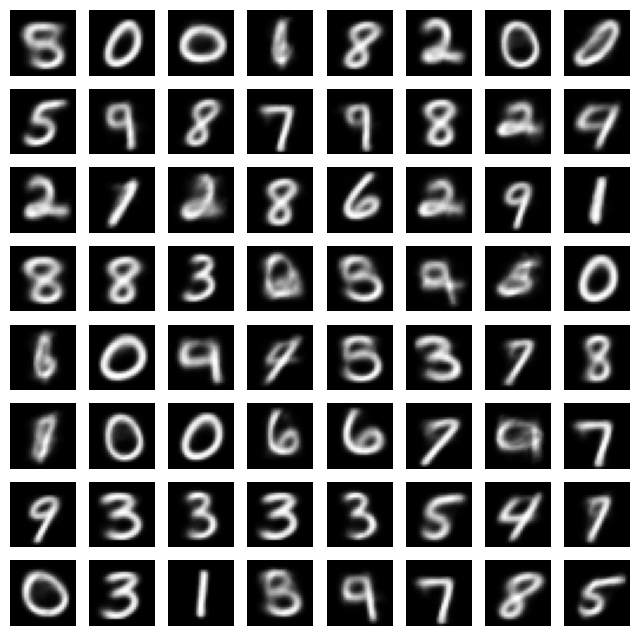

In [15]:
z = torch.randn(64, latent_dim).to(device)
samples = model.decode(z)
# samples = torch.sigmoid(samples)

# print first sample
# print(samples[0])

# Plot the generated images
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(samples[i*8+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
        ax[i, j].axis('off')

# plt.show()
plt.savefig('vae_mnist.webp')

In [16]:
# encode and plot the z values for the train set 
model.eval()
z_all = []
y_all = []
with torch.no_grad():
    for data, target in tqdm(train_loader, desc='Encoding'):
        data = data.to(device)
        output = model(data, compute_loss=False)
        z_all.append(output.z_sample.cpu().numpy())
        y_all.append(target.numpy())

Encoding:   0%|          | 0/469 [00:00<?, ?it/s]

In [17]:
import numpy as np
z_all = np.concatenate(z_all, axis=0)
y_all = np.concatenate(y_all, axis=0)

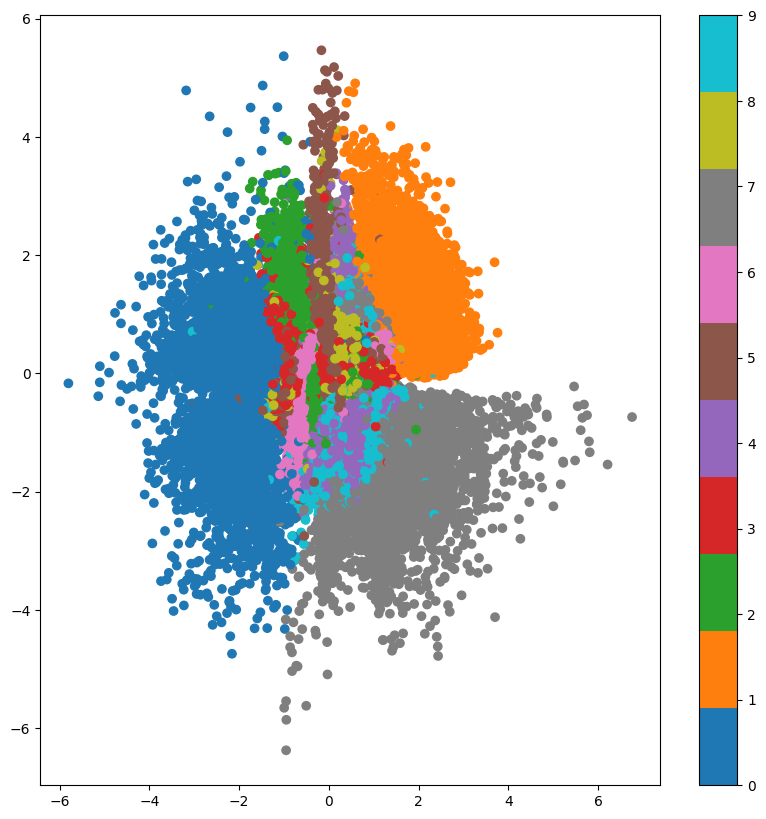

In [18]:
plt.figure(figsize=(10, 10))
plt.scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10')
plt.colorbar()
# plt.show()
plt.savefig('vae_mnist_2d_scatter.webp')

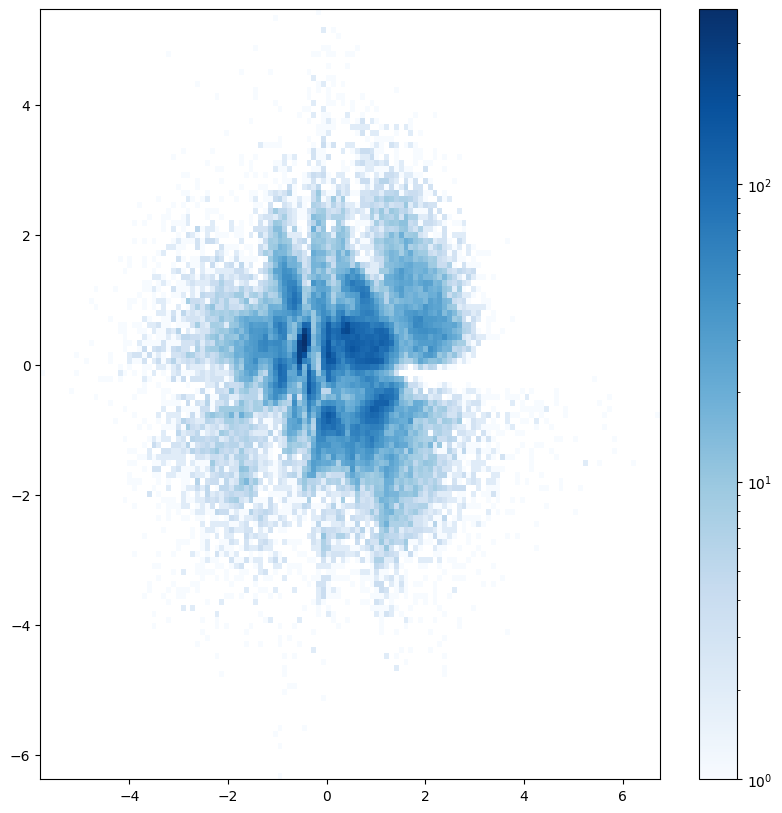

In [19]:
# plot as 2d histogram, log scale
from matplotlib.colors import LogNorm
plt.figure(figsize=(10, 10))
plt.hist2d(z_all[:, 0], z_all[:, 1], bins=128, cmap='Blues', norm=LogNorm())
plt.colorbar()
# plt.show()
plt.savefig('vae_mnist_2d_hist.webp')

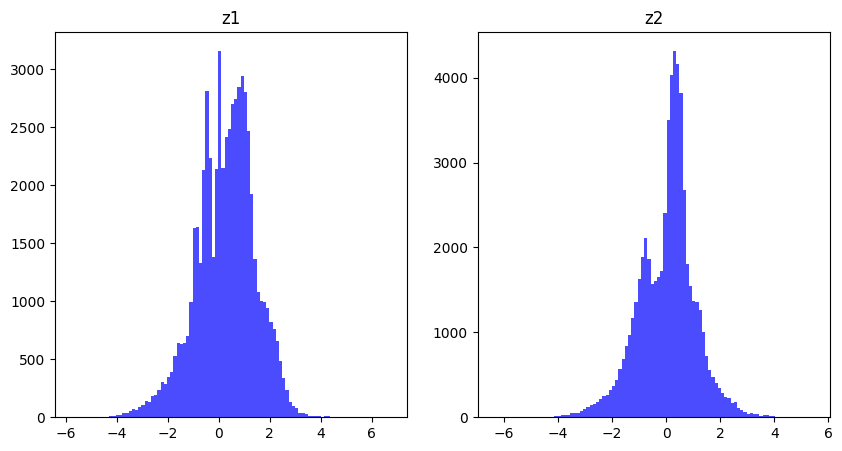

In [20]:
# plot 1d histograms
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(z_all[:, 0], bins=100, color='b', alpha=0.7)
ax[0].set_title('z1')
ax[1].hist(z_all[:, 1], bins=100, color='b', alpha=0.7)
ax[1].set_title('z2')
# plt.show()
plt.savefig('vae_mnist_1d_hist.webp')

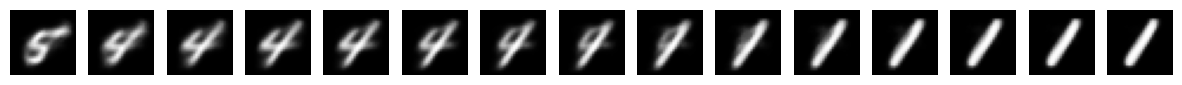

In [21]:
n = 15
z1 = torch.linspace(-0, 1, n)
z2 = torch.zeros_like(z1) + 2
z = torch.stack([z1, z2], dim=-1).to(device)
samples = model.decode(z)
samples = torch.sigmoid(samples)

# Plot the generated images
fig, ax = plt.subplots(1, n, figsize=(n, 1))
for i in range(n):
    ax[i].imshow(samples[i].view(28, 28).cpu().detach().numpy(), cmap='gray')
    ax[i].axis('off')
    
plt.savefig('vae_mnist_interp.webp')